In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time # pour comparer les algorithmes en fonction de leur durée d'éxecution
import multiprocessing
import concurrent.futures #librairie pour le multiprocessing
from scipy import optimize

# Table des matières

*[Section 1 : Construction des données](#section0)

*[Section 2 : Implémentation de CoCoA avec SDCA](#section1)

*[Section 3 : Implémentation de ADMM distribuée](#section2)

*[Section 4 : Implémentation de ADMM non distribuée](#section3)

*[Section 5 : Etude de la convergence pour une taille de X variante](#section4)

*[Section 6 : Conclusion](#section5)

<a id='section0'></a>

# Construction des données

## Nous construisons les données de test

In [2]:
np.random.seed(0)

def binarize(x):
    return np.sign(x)

n_samples, n_features = 4000, 40
X = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = binarize(X.dot(w) + 0.1 * np.random.randn(n_samples))

## Nous définissons les constantes

In [3]:
lam = 1./n_features
T = 200
n_proc=4
tau=1.

<a id='section1'></a>

# Implémentation de CoCoA avec SDCA

## SDCA

Ici nous programmons la fonction de coût qui permet d'étudier la convergence de l'algorithme. 
Elle correspond à la fonction objective de la regression logistique comme défini dans le TD ADMM :
$$
    \frac{1}{n} \sum_{i=1}^n -\log(\frac{1}{1 + e^{-b_i w_i^T x}})+\frac{\tau}{2}\|w-\rho+u\|_2+ \lambda\|w\|_1
$$

In [4]:
def obj_log_loss(w,lam):
    
    rho = np.zeros(n_features)
    u = np.zeros(n_features)
    rho = np.fmax(w + u - lam /tau, 0)\
            - np.fmax(-lam/tau - w - u, 0)
    u = u + w - rho

    p = b * X.dot(w)
    t = 1.0 + np.exp(-p)
    return -np.sum(np.log(1.0 / t)) / n_samples + lam * np.linalg.norm(w, ord=1) \
    + (tau / 2.) * np.linalg.norm(w - rho + u) ** 2
        
        


Nous programmons ci-dessous l'algorithme SDCA qui sera distribué par la suite avec la méthode CoCoA

![](SDCA.png)

Afin de maximiser le gradient de $\alpha_i$ nous utilisons la formule fermée de l'article <a href="https://arxiv.org/pdf/1209.1873.pdf">*Stochastic Dual Coordinate Ascent Methods for Regularized Loss Minimization*</a> de **Shai Shalev-Shwartz** et **Tong Zhang** décrite ci-dessous :

![](Formule_ferme.png)
    

In [5]:
def SDCA(X,b,w,alpha,T,lam,n_samples):
    
    # initialisation
    gradient_alpha = np.zeros(n_samples)
    
    
    for t in range(0,T):
        
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)
        
        delta_alpha_i = ((1+np.exp(X[idx].T.dot(w)*b[idx]))**(-1)*b[idx]-alpha[idx])\
        /max(1,0.25+(np.linalg.norm(X[idx]))**2/(lam*n_samples))
        
        alpha[idx] = alpha[idx] + delta_alpha_i
        
        gradient_alpha[idx]=gradient_alpha[idx] + delta_alpha_i
        
        w = w+(1/(lam*n_samples))*delta_alpha_i*X[idx]
    
    gradient_w=(1/(lam*n_samples))*X.T.dot(gradient_alpha)
    
    return gradient_alpha,gradient_w

## CoCoA

Afin de distribuer nos calculs nous avons choisi de mettre en place la méthode CoCoA
comme définie dans l'article <a href="https://arxiv.org/pdf/1409.1458.pdf">
*Communication-Efficient Distributed Dual Coordinate Ascent*</a> de **Virginia Smith** and al.

![](CoCoA.png)

In [6]:
def COCOA(T,lam,X,b,n_samples):
    
     # on déclenche le timer
    t0 = time.time()
    #H=n_proc #comme dans le code de l'article COCOA (driver scala)
    H=100
    #on initialise l'output de cocoa
    futures = []
    beta_k=1
    alpha=np.zeros((int(n_samples/n_proc),n_proc))
    grad_alpha = np.zeros((int(n_samples/n_proc),n_proc))
    grad_w = np.zeros((n_features,n_proc))
    
    w = np.zeros(n_features)
    
    
    # on split les données
    X_split = np.array_split(X, n_proc)
    b_split = np.array_split(b, n_proc)
    
    # historique des fonctions de perte
    cost_history = np.empty(shape=[T])
    time_history = np.empty(shape=[T,2])
    
    for t in range(0,T):
        
        cost_history[t] = obj_log_loss(w, lam)
        time_history[t] = (time.time()-t0, cost_history[t])
        
        with concurrent.futures.ProcessPoolExecutor() as executor: 
            for k in range(n_proc):
                futures.append(executor.submit(SDCA,X_split[k],b_split[k],w,alpha[:,k],H,lam,int(n_samples/n_proc)))
            
        concurrent.futures.wait(futures) # on attend la synchronisation     
        
        for k in range(n_proc):
            d=int(t*n_proc+k)
            grad_w[:,k]=futures[d].result()[1]#dernier
            grad_alpha[:,k]=futures[d].result()[0]#dernier
            alpha[:,k]=alpha[:,k]+(beta_k/n_proc)*(grad_alpha[:,k])
            
        w=w+(beta_k/n_proc)*(np.sum(grad_w,axis=1))
        
        

    return time_history



In [9]:
cost_history_SDCA = COCOA(T=T,lam=lam,X=X,b=b,n_samples=n_samples)

## Etude de la convergence

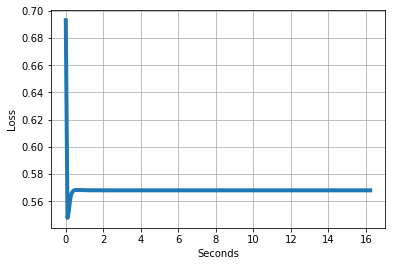

In [27]:
plt.plot(cost_history_SDCA[:,0],cost_history_SDCA[:,1], lw=4)
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Seconds')
plt.show()

Notre algorithme converge bien, nous étudierons sa performance 
comparativement à une méthode de distribution naïve

<a id='section2'></a>

# Implémentation de ADMM distribuée 

In [7]:
def logistic_loss(theta,rho,u,tau):
        p = b * X.dot(theta)
        t = 1.0 + np.exp(-p)
        return -np.sum(np.log(1.0 / t)) / n_samples\
        + (tau / 2.) * np.linalg.norm(theta - rho + u) ** 2

def ADMM_logloss_distribue(A,b,theta,rho,u,tau,n_k,lam=1.):
    
    # meme fonction que plus haut mais sans argument pour faire la minimisation
    def logistic_loss_optim(theta):
        p = b * A.dot(theta)
        t = 1.0 + np.exp(-p)
        return -np.sum(np.log(1.0 / t)) / n_k\
        + (tau / 2.) * np.linalg.norm(theta - rho + u) ** 2

    def logistic_grad(theta):
        t = b * A.dot(theta)
        z = 1. / (1 + np.exp(-t))
        z0 = (z - 1) * b
        grad_w = A.T.dot(z0)
        return grad_w / n_k\
           + tau * (theta - rho + u)
    
    theta = optimize.minimize(
        logistic_loss_optim, theta, jac=logistic_grad).x
  
    return theta

def distribution_calcul_ADMM_logloss(A, b, lam,max_iter):
    
    # .. initialize variables ..
    rho = np.zeros(n_features)
    u = np.zeros(n_features)
    theta = np.zeros(n_features)
    theta_intermediaire= np.zeros((n_features,n_proc))
    
     # .. to keep track of progress ..
    t0=time.time()

    obj_fun_history = np.empty(shape=[T,2])
    
    # on split les données
    A_split = np.array_split(A, n_proc)
    b_split = np.array_split(b, n_proc)
    futures=[]
    
    # distribution des calculs
    for t in range(max_iter):
        
        obj_fun_history[t]=((time.time()-t0),(logistic_loss(theta,rho,u,tau)\
                               + lam * np.sum(np.abs(theta))))
        
        with concurrent.futures.ProcessPoolExecutor() as executor: 
            for k in range(n_proc):
                futures.append(executor.submit(ADMM_logloss_distribue,A_split[k],b_split[k],theta\
                                               ,rho,u,tau,int(n_samples/n_proc)))
            
        concurrent.futures.wait(futures) # on attend la synchronisation     
        
        for k in range(n_proc):
            d=int(t*n_proc+k)
            theta_intermediaire[:,k]=futures[d].result()#dernier
        
        # ATTENTION A DISCUTER ENSEMBLE DOIT ON FAIRE UN THETA GLOBAL JUSTE POUR LA MISE A JOUR
        # ET METTRE LES THETA K DANS LES MACHINES OU METTRE LE MEME THETA DE MEME POUR U
        
        # on met a jour le theta global comme la moyenne des theta intermediaire
        theta=np.mean(theta_intermediaire,axis=1)
        
        rho = np.fmax(theta + u - lam /tau, 0) - np.fmax(-lam/tau - theta - u, 0)
        
        u = u + theta - rho
        
    return obj_fun_history
    


In [61]:
func_vals_ADMM_distrib = distribution_calcul_ADMM_logloss(X, b, max_iter=T, lam=lam)

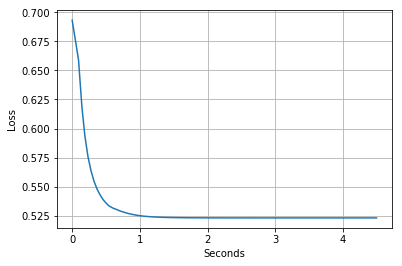

In [62]:
plt.plot(func_vals_ADMM_distrib[:,0],func_vals_ADMM_distrib[:,1])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Seconds')
plt.show()

<a id='section3'></a>

# Implémentation de ADMM non distribuée

In [8]:
def ADMM_logloss(A, b, max_iter,lam):
    # .. initialize variables ..
    rho = np.zeros(n_features)
    u = np.zeros(n_features)
    theta = np.zeros(n_features)
    
    # .. to keep track of progress ..
    t0=time.time()

    obj_fun_history = np.empty(shape=[T,2])

    # .. cache inverse matrix ..
    for t in range(max_iter):
        
        def logistic_loss(theta):
            p = b * A.dot(theta)
            t = 1.0 + np.exp(-p)
            return -np.sum(np.log(1.0 / t)) / n_samples\
            + (tau / 2.) * np.linalg.norm(theta - rho + u) ** 2

        def logistic_grad(theta):
            t = b * A.dot(theta)
            z = 1. / (1 + np.exp(-t))
            z0 = (z - 1) * b
            grad_w = A.T.dot(z0) 
            return grad_w / n_samples\
               + tau * (theta - rho + u)
        
        obj_fun_history[t]=((time.time()-t0),(logistic_loss(theta)\
                               + lam * np.sum(np.abs(theta))))

        theta = optimize.minimize(
            logistic_loss, theta, jac=logistic_grad).x
        rho = np.fmax(theta + u - lam /tau, 0)\
                - np.fmax(-lam/tau - theta - u, 0)
        u = u + theta - rho
        
    return obj_fun_history
    


In [9]:
func_vals_ADMM = ADMM_logloss(X, b,max_iter=T, lam=lam)

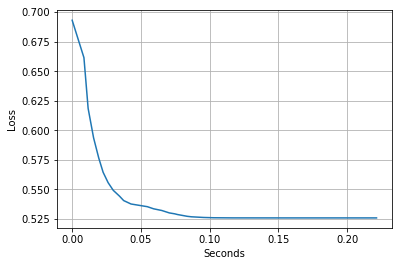

In [10]:
plt.plot(func_vals_ADMM[:,0],func_vals_ADMM[:,1])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Seconds')
plt.show()

<a id='section4'></a>

# Etude de la convergence pour une taille de X variante

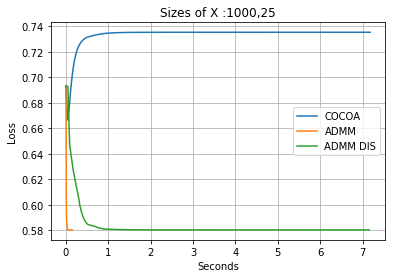

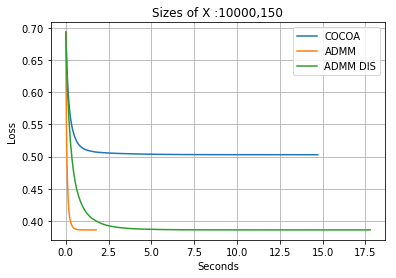

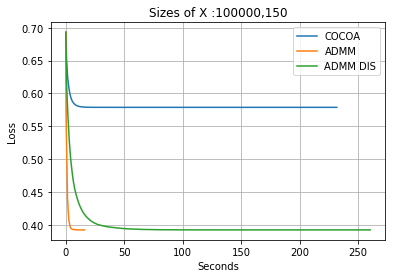

In [ ]:
for i in range(3,7):
    n_samples=10**i
    n_features=int(min((n_samples/n_proc)/10,150)) # on s'assure de ne jamais avoir plus de features que
    # d'obs dans chaque machine
    
    X = np.random.randn(n_samples, n_features)
    w = np.random.randn(n_features)
    b = binarize(X.dot(w) + 0.1 * np.random.randn(n_samples))
    lam = 1./n_features
    #CoCoA
    func_vals_COCOA = COCOA(T=T,lam=lam,X=X,b=b,n_samples=n_samples)
    
    #ADMM non distribue
    func_vals_ADMM = ADMM_logloss(X, b,max_iter=T, lam=lam)
    
    #ADMM distribue
    func_vals_ADMM_distrib = distribution_calcul_ADMM_logloss(X, b, max_iter=T, lam=lam)
    
    plt.plot(func_vals_COCOA[:,0],func_vals_COCOA[:,1],label='COCOA')
    plt.plot(func_vals_ADMM[:,0],func_vals_ADMM[:,1],label='ADMM')
    plt.plot(func_vals_ADMM_distrib[:,0],func_vals_ADMM_distrib[:,1],label='ADMM DIS')
    plt.grid()
    plt.title('Sizes of X :%d,%d' %(n_samples,n_features))
    plt.ylabel('Loss')
    plt.xlabel('Seconds')
    plt.legend()
    plt.show()

<a id='section5'></a>

# Conclusion